## Import Packages

In [14]:
DATA_DIR = '/kaggle/input/learn-together'
DATA_DIR = 'data'

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score, calinski_harabasz_score, silhouette_score



import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/train.csv
data/test.csv
data/sample_submission.csv
data/sample_submission.csv.zip
data/input
data/test.csv.zip
data/train.csv.zip


## Load Dataset

In [16]:
train_df=pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

test_df=pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

## Delete Ids
**Let's delete the Id column in the training set but store it for the test set before deleting**

In [17]:
train_df = train_df.drop(["Id"], axis = 1)

test_ids = test_df["Id"]
test_df = test_df.drop(["Id"], axis = 1)

In [18]:
y = train_df['Cover_Type']
X = train_df.drop(['Cover_Type'], axis=1)

# Feature engineering

In [19]:
train_df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [20]:
X[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']].describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
count,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.237897,0.033003,0.419907,0.309193
std,0.425810,0.178649,0.493560,0.462176
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [21]:
test_df[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']].describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
count,565892.000000,565892.000000,565892.000000,565892.000000
mean,0.454502,0.051927,0.436506,0.057066
std,0.497926,0.221880,0.495953,0.231968
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [22]:

def new_features(df):
    df = df.copy()
    df['Hydro_Elevation_diff'] = df[['Elevation',
                                   'Vertical_Distance_To_Hydrology']
                                  ].diff(axis='columns').iloc[:, [1]]

    df['Hydro_Euclidean'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 +
                                   df['Vertical_Distance_To_Hydrology']**2)

    df['Hydro_Fire_sum'] = df[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Fire_Points']
                            ].sum(axis='columns')

    df['Hydro_Fire_diff'] = df[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    df['Hydro_Road_sum'] = df[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Roadways']
                            ].sum(axis='columns')

    df['Hydro_Road_diff'] = df[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    df['Road_Fire_sum'] = df[['Horizontal_Distance_To_Roadways',
                            'Horizontal_Distance_To_Fire_Points']
                           ].sum(axis='columns')

    df['Road_Fire_diff'] = df[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].diff(axis='columns').iloc[:, [1]].abs()
    df['Stoneyness'] = sum(i * df['Soil_Type{}'.format(i)] for i in range(1, 41))

    # For all 40 Soil_Types, 1=rubbly, 2=stony, 3=very stony, 4=extremely stony, 0=?
    stoneyness = [4, 3, 1, 1, 1, 2, 0, 0, 3, 1, 
                  1, 2, 1, 0, 0, 0, 0, 3, 0, 0, 
                  0, 4, 0, 4, 4, 3, 4, 4, 4, 4, 
                  4, 4, 4, 4, 1, 4, 4, 4, 4, 4]

    # Replace Soil_Type number with "stoneyness" value
    df['Stoneyness'] = df['Stoneyness'].replace(range(1, 41), stoneyness)
    return df
    
def drop_features(df):
    df = df.copy()
    columns_to_drop = []
    size = len(df)
    for column in df.columns:
        frequency = df[column].sum() / size
        if 'Soil' in column and frequency < 0.04:
            columns_to_drop.append(column)
        columns_to_drop.append('Wilderness_Area4')  # Frequency between test and train too diferent
    df = df.drop(columns_to_drop, axis='columns')
    return df
    

In [23]:
X = new_features(X)
X = drop_features(X)
X_test = new_features(test_df)
X_test = X_test[X.columns]

In [24]:
X.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type6', 'Soil_Type10', 'Soil_Type17', 'Soil_Type23',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type32', 'Soil_Type33',
       'Soil_Type38', 'Soil_Type39', 'Hydro_Elevation_diff', 'Hydro_Euclidean',
       'Hydro_Fire_sum', 'Hydro_Fire_diff', 'Hydro_Road_sum',
       'Hydro_Road_diff', 'Road_Fire_sum', 'Road_Fire_diff', 'Stoneyness'],
      dtype='object')

In [25]:
X[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000


In [26]:
X[['Hydro_Elevation_diff', 'Hydro_Euclidean', 'Hydro_Fire_sum',
       'Hydro_Fire_diff', 'Hydro_Road_sum', 'Hydro_Road_diff', 'Road_Fire_sum',
       'Road_Fire_diff', 'Stoneyness']].describe()

,Hydro_Elevation_diff,Hydro_Euclidean,Hydro_Fire_sum,Hydro_Fire_diff,Hydro_Road_sum,Hydro_Road_diff,Road_Fire_sum,Road_Fire_diff,Stoneyness
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,-2698.246032,235.948778,1738.342989,1291.834788,1941.218915,1492.094577,3225.170503,897.908333,2.333003
std,414.680029,215.491695,1152.123001,1077.167415,1383.173588,1292.673425,2093.672478,884.718318,1.580487
min,-3776.000000,0.000000,30.000000,0.000000,30.000000,0.000000,95.000000,0.000000,0.000000
25%,-3068.000000,67.186308,903.000000,532.000000,967.000000,534.000000,1806.000000,291.000000,1.000000
50%,-2696.000000,188.480768,1462.000000,1023.500000,1501.000000,1148.000000,2520.500000,632.000000,2.000000
75%,-2323.000000,342.069071,2302.000000,1726.000000,2554.000000,2042.000000,4232.250000,1220.000000,4.000000
max,-1842.000000,1356.939571,7167.000000,6898.000000,7306.000000,6860.000000,12504.000000,6012.000000,4.000000


In [27]:
X[['Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type6', 'Soil_Type10',
       'Soil_Type17', 'Soil_Type23', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39']].describe()

,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type6,Soil_Type10,Soil_Type17,Soil_Type23,Soil_Type29,Soil_Type30,Soil_Type32,Soil_Type33,Soil_Type38,Soil_Type39
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.041204,0.063624,0.055754,0.042989,0.141667,0.040476,0.050066,0.085384,0.047950,0.045635,0.040741,0.048148,0.043452
std,0.198768,0.244091,0.229454,0.202840,0.348719,0.197080,0.218089,0.279461,0.213667,0.208699,0.197696,0.214086,0.203880
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
X['Stoneyness'].value_counts()

4    6546
1    5096
0    1854
2     877
3     747
Name: Stoneyness, dtype: int64

# Cluster features

In [29]:
ss = StandardScaler()
X_all = np.vstack([X, X_test])
ss.fit(X_all)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
cluster_data = ss.transform(X)
cluster_data_test = ss.transform(X_test)
cluster_data_all = np.vstack([cluster_data, cluster_data_test])

In [62]:
n_components = [r for r in range(5, 16)]
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster_data)
          for n in n_components]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.plot(n_components, [silhouette_score(m.predict(X)) for m in models], label='Silhouette')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
from collections import OrderedDict

# TODO: Apply your clustering algorithm of choice to the reduced data
def make_cluster(clusterer, X):
    # clusterer.fit(reduced_data)
    preds = clusterer.fit_predict(X)
    score = silhouette_score(X, preds)
    return clusterer, score

In [74]:
kclusters = []
kscores = {}
for n in range(5, 16):
    kmeans = KMeans(n_clusters=n, random_state=13)
    kmeans.fit(cluster_data)
    kscores[n] = (silhouette_score(cluster_data, kmeans.labels_),
                  completeness_score(y, kmeans.labels_))


In [ ]:
gscores = {}
for n, gmm in enumerate(models, 5):
    labels = gmm.predict(cluster_data)
    gscores[n] = (silhouette_score(cluster_data, labels),
                  completeness_score(y, labels))

In [80]:
ksil = [score[0] for score in kscores.values()]
gsil = [score[0] for score in gscores.values()]
kcom = [score[1] for score in kscores.values()]
gcom = [score[1] for score in gscores.values()]

Text(0.5, 0, 'scores')

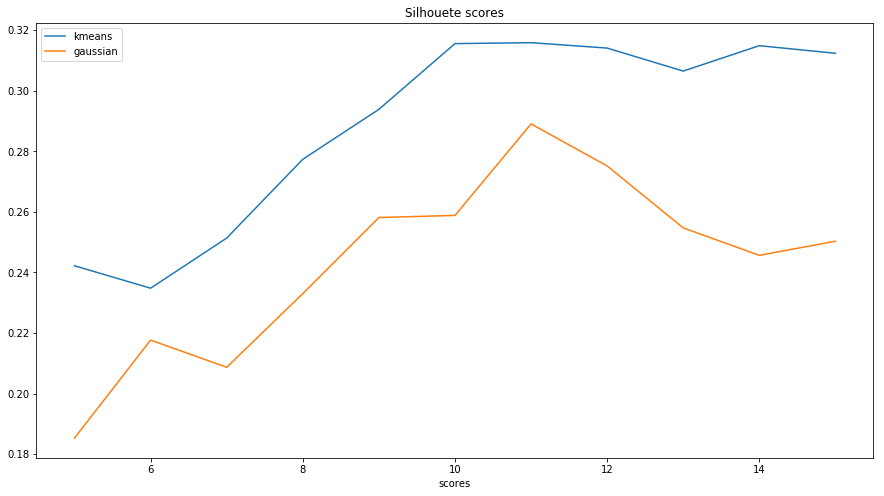

In [81]:
plt.figure(figsize=(15, 8))
plt.title('Silhouete scores')
plt.plot(kscores.keys(), ksil, label='kmeans')
plt.plot(gscores.keys(), gsil, label='gaussian')
plt.legend()
plt.xlabel('number of clusters')
plt.xlabel('scores')

Text(0.5, 0, 'scores')

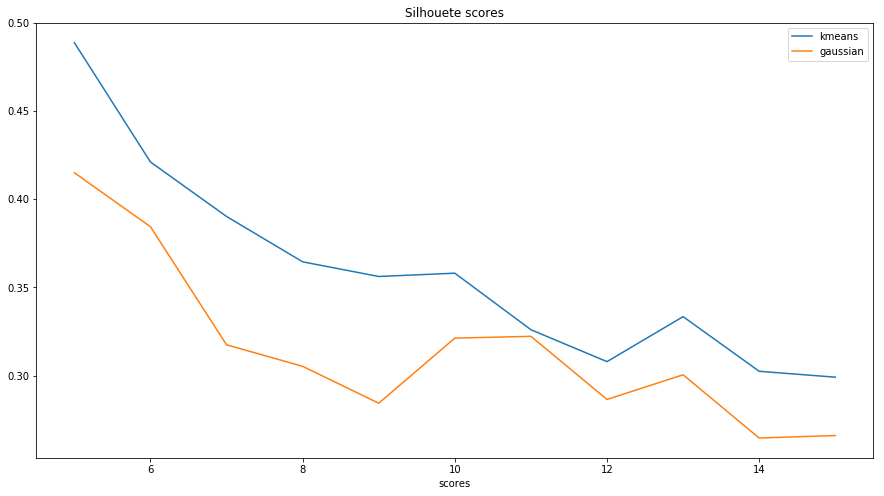

In [82]:
plt.figure(figsize=(15, 8))
plt.title('Completeness scores')
plt.plot(kscores.keys(), kcom, label='kmeans')
plt.plot(gscores.keys(), gcom, label='gaussian')
plt.legend()
plt.xlabel('number of clusters')
plt.xlabel('scores')

In [31]:
km = KMeans(10)
km.fit(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [32]:
print(completeness_score(y, km.labels_))
print(silhouette_score(cluster_data, km.labels_))
print(calinski_harabasz_score(cluster_data, km.labels_))

0.3435769760465903
0.3170923866073176
3420.9547836846236


In [33]:
X['cluster'] = km.predict(cluster_data)
X_test['cluster'] = km.predict(cluster_data_test)

In [34]:
gmm = GaussianMixture(11)
gmm.fit(cluster_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [36]:
labels = gmm.predict(cluster_data)
print(completeness_score(y, labels))
print(silhouette_score(cluster_data, labels))
print(calinski_harabasz_score(cluster_data, labels))

0.3222624924003905
0.2890408341359559
2952.0624164611727


In [37]:
X['cluster2'] = labels
X_test['cluster2'] = gmm.predict(cluster_data_test)

## Brute Force parameter searchs

In [22]:
X_filtered = X[y < 3]
y_filtered = y[y < 3]

In [23]:
# A simple first test to validate features of actual df
etc = ExtraTreesClassifier(
    bootstrap=True, oob_score=True,
    **{'max_depth': 30, 'n_estimators': 1000, 'max_features': 0.7}
    )
etc.fit(X_filtered, y_filtered)
etc.oob_score_

0.85

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = [200, 400, 600, 800, 1000, 1200, 1400]
train_scores, test_scores = validation_curve(
    ExtraTreesClassifier(),
    X_filtered, y_filtered,
    param_name="n_estimators",
    param_range=param_range,
    cv=5, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

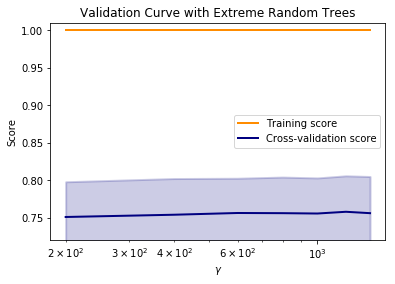

In [38]:
plt.title("Validation Curve with Extreme Random Trees")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.72, 1.01)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [35]:
from time import time
from sklearn.model_selection import RandomizedSearchCV



In [118]:
param_dist = {"max_depth": [10, 20, 32, 50, None],
              'max_features': [0.4, 0.6, 0.7, 0.8, 0.9],
              'n_estimators': [50, 100, 200, 600, 900, 1200]
             }


def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
n_iter_search = 10
random_search = RandomizedSearchCV(LGBMClassifier(bootstrap=False),
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(X_filtered, y_filtered)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 67.85 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.749 (std: 0.041)
Parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': 0.4}

Model with rank: 2
Mean validation score: 0.748 (std: 0.042)
Parameters: {'n_estimators': 200, 'max_depth': 50, 'max_features': 0.4}

Model with rank: 2
Mean validation score: 0.748 (std: 0.042)
Parameters: {'n_estimators': 200, 'max_depth': 32, 'max_features': 0.6}

Model with rank: 4
Mean validation score: 0.748 (std: 0.041)
Parameters: {'n_estimators': 200, 'max_depth': 20, 'max_features': 0.7}

Model with rank: 5
Mean validation score: 0.747 (std: 0.042)
Parameters: {'n_estimators': 600, 'max_depth': None, 'max_features': 0.9}

Model with rank: 6
Mean validation score: 0.745 (std: 0.041)
Parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': 0.8}

Model with rank: 7
Mean validation score: 0.743 (std: 0.040)
Parameters: {'n_estimators': 100, 'max_depth': 50, 'max_f

In [92]:
X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_filtered, test_size=0.2)

In [66]:
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)
predictions = cls.predict(X_val)
accuracy_score(y_val, predictions)

[WARNING] [2019-09-11 13:56:11,519:EnsembleBuilder(1):ea054111732bd027f6a1d05493b599c0] No models better than random - using Dummy Score!
[WARNING] [2019-09-11 13:56:11,524:EnsembleBuilder(1):ea054111732bd027f6a1d05493b599c0] No models better than random - using Dummy Score!
[WARNING] [2019-09-11 13:56:43,018:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-09-11 13:56:43,018:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
1
['/tmp/autosklearn_tmp_11054_6865/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_11054_6865/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_11054_6865/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_11054_6865/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_11054_6865/.auto-sklearn/ensembles/1.0000000004.ensemble', '/tmp/

0.8020833333333334

In [116]:
etc = ExtraTreesClassifier(
    **{'max_depth': None, 'n_estimators': 200, 'max_features': 0.8}
    )
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=0.8, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [117]:
y_pred = etc.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.8229166666666666
              precision    recall  f1-score   support

           1       0.83      0.81      0.82       437
           2       0.81      0.84      0.82       427

    accuracy                           0.82       864
   macro avg       0.82      0.82      0.82       864
weighted avg       0.82      0.82      0.82       864

[[354  83]
 [ 70 357]]


In [103]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    **{'max_depth': None, 'n_estimators': 200, 'max_features': 0.8}
    )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
y_pred = etc.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.8240740740740741
              precision    recall  f1-score   support

           1       0.85      0.80      0.82       437
           2       0.80      0.85      0.83       427

    accuracy                           0.82       864
   macro avg       0.82      0.82      0.82       864
weighted avg       0.83      0.82      0.82       864

[[349  88]
 [ 64 363]]


In [166]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(bootstrap=False,
    **{'n_estimators': 900, 'max_depth': 20, 'max_features': 0.4}

    )
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
               colsample_bytree=1.0, learning_rate=0.1, max_depth=20,
               max_features=0.4, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=900, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=1)

In [167]:
y_pred_train = lgb.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

y_pred = lgb.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

1.0
0.8333333333333334
              precision    recall  f1-score   support

           1       0.84      0.83      0.83       437
           2       0.83      0.84      0.83       427

    accuracy                           0.83       864
   macro avg       0.83      0.83      0.83       864
weighted avg       0.83      0.83      0.83       864

[[363  74]
 [ 70 357]]


In [142]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [143]:
y_pred_train = knn.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

y_pred = knn.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.8388310185185185
0.7326388888888888
              precision    recall  f1-score   support

           1       0.73      0.74      0.74       437
           2       0.73      0.72      0.73       427

    accuracy                           0.73       864
   macro avg       0.73      0.73      0.73       864
weighted avg       0.73      0.73      0.73       864

[[325 112]
 [119 308]]


In [114]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    
    )
xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
y_pred = xgb.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.7662037037037037
              precision    recall  f1-score   support

           1       0.77      0.77      0.77       437
           2       0.76      0.76      0.76       427

    accuracy                           0.77       864
   macro avg       0.77      0.77      0.77       864
weighted avg       0.77      0.77      0.77       864

[[337 100]
 [102 325]]


## TRAIN FINAL MODEL

In [27]:
X_, X_val, y_, y_val = train_test_split(X, y, test_size=0.1)
X_filtered = X_[y < 3]
y_filtered = y_[y < 3]

In [41]:
## Model for classs 1 x class 2
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(bootstrap=False,
    **{'n_estimators': 900, 'max_depth': 20, 'max_features': 0.4}

    )

In [92]:
lgb.fit(X_filtered, y_filtered)

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=20, max_features=0.4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=900,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [29]:
y_pred = lgb.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.23875661375661375
              precision    recall  f1-score   support

           1       0.41      0.83      0.55       212
           2       0.17      0.86      0.29       216
           3       0.00      0.00      0.00       203
           4       0.00      0.00      0.00       235
           5       0.00      0.00      0.00       214
           6       0.00      0.00      0.00       223
           7       0.00      0.00      0.00       209

    accuracy                           0.24      1512
   macro avg       0.08      0.24      0.12      1512
weighted avg       0.08      0.24      0.12      1512

[[175  37   0   0   0   0   0]
 [ 30 186   0   0   0   0   0]
 [  0 203   0   0   0   0   0]
 [  0 235   0   0   0   0   0]
 [ 12 202   0   0   0   0   0]
 [  2 221   0   0   0   0   0]
 [206   3   0   0   0   0   0]]


In [30]:
y_pred = lgb.predict(X_filtered)
print(accuracy_score(y_filtered, y_pred))
print(classification_report(y_filtered, y_pred))
print(confusion_matrix(y_filtered, y_pred))

1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1948
           2       1.00      1.00      1.00      1944

    accuracy                           1.00      3892
   macro avg       1.00      1.00      1.00      3892
weighted avg       1.00      1.00      1.00      3892

[[1948    0]
 [   0 1944]]


# Mount the ensemble

In [31]:
X_, X_val, y_, y_val = train_test_split(X, y, test_size=0.2)

### Trees Classifiers and ensemble

In [42]:
rf = RandomForestClassifier(n_estimators=200,
                            bootstrap=False)
# rf.fit(X_, y_)

In [43]:
etc = ExtraTreesClassifier(
    bootstrap=False,
    **{'max_depth': 32, 'n_estimators': 500, 'max_features': 0.4}
    )
# etc.fit(X_, y_)

In [44]:
lgb2 = LGBMClassifier(n_estimators=400,
                      num_leaves=100)
# lgb2.fit(X_, y_)

In [45]:
from mlxtend.classifier import StackingCVClassifier

ensemble = [('etc', etc),
            ('rf', rf),
            ('lgb', lgb2)]

stack = StackingCVClassifier(classifiers=[clf for label, clf in ensemble],
                             meta_classifier=etc,
                             cv=5,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=1,
                             random_state=0)

In [35]:
stack.fit(X_, y_)

Fitting 3 classifiers...
Fitting classifier1: extratreesclassifier (1/3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: randomforestclassifier (2/3)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/3)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.0s finished


StackingCVClassifier(classifiers=[ExtraTreesClassifier(bootstrap=False,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=32,
                                                       max_features=0.4,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=500,
                                                       n_jobs=None,
                        

In [36]:
print(stack.score(X_, y_))
print(stack.score(X_val, y_val))

0.9995039682539683
0.8984788359788359


In [37]:
y_pred = stack.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[360  61   0   0   3   0  11]
 [ 61 347  10   0  16   7   1]
 [  0   6 401  17   1  35   0]
 [  0   0   7 395   0   5   0]
 [  0  10   2   0 400   3   0]
 [  0   0  31   5   2 384   0]
 [ 11   2   0   0   0   0 430]]
              precision    recall  f1-score   support

           1       0.83      0.83      0.83       435
           2       0.81      0.79      0.80       442
           3       0.89      0.87      0.88       460
           4       0.95      0.97      0.96       407
           5       0.95      0.96      0.96       415
           6       0.88      0.91      0.90       422
           7       0.97      0.97      0.97       443

    accuracy                           0.90      3024
   macro avg       0.90      0.90      0.90      3024
weighted avg       0.90      0.90      0.90      3024



### Combinar com classificador da classe 1 x 2

In [38]:
y_pred_proba_1x2 = lgb.predict_proba(X_val)

In [39]:
y_pred_proba = stack.predict_proba(X_val)

In [55]:
def combine_predictions(pred_proba_12, pred_proba):
    pred_proba_ensembled = pred_proba.copy()
    pred_proba_ensembled[:, :2] = np.clip(pred_proba[:, :2] * (1 + 1.9 * np.log(pred_proba_12 + 0.85)), 0., 1.)
    return np.argmax(pred_proba_ensembled, axis = 1) + 1
    

In [83]:
y_pred_ensembled = combine_predictions(y_pred_proba_1x2, y_pred_proba)

In [84]:
(y_pred_ensembled != y_pred).sum() / len(y_pred)

0.041666666666666664

In [85]:
print(accuracy_score(y_val, y_pred_ensembled))
print(classification_report(y_val, y_pred_ensembled))
print(confusion_matrix(y_val, y_pred_ensembled))


0.9265873015873016
              precision    recall  f1-score   support

           1       0.94      0.93      0.94       435
           2       0.90      0.91      0.90       442
           3       0.89      0.86      0.88       460
           4       0.95      0.97      0.96       407
           5       0.95      0.95      0.95       415
           6       0.88      0.91      0.89       422
           7       0.98      0.96      0.97       443

    accuracy                           0.93      3024
   macro avg       0.93      0.93      0.93      3024
weighted avg       0.93      0.93      0.93      3024

[[406  16   0   0   5   0   8]
 [ 12 401   8   0  12   7   2]
 [  0  11 396  17   1  35   0]
 [  0   0   7 395   0   5   0]
 [  0  15   2   0 395   3   0]
 [  0   3  31   5   1 382   0]
 [ 15   1   0   0   0   0 427]]


### Fit with all data

In [46]:
X_filtered2 = X[y < 3]
y_filtered2 = y[y < 3]
lgb.fit(X_filtered2, y_filtered2)

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=20, max_features=0.4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=900,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [47]:
stack.fit(X, y)

Fitting 3 classifiers...
Fitting classifier1: extratreesclassifier (1/3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: randomforestclassifier (2/3)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/3)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.9s finished


StackingCVClassifier(classifiers=[ExtraTreesClassifier(bootstrap=False,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=32,
                                                       max_features=0.4,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=500,
                                                       n_jobs=None,
                        

In [94]:
y_pred_proba = stack.predict_proba(X_val)
y_pred_proba_12 = lgb.predict_proba(X_val)
y_ensembled = combine_predictions(y_pred_proba_12, y_pred_proba)
print(confusion_matrix(y_val, y_ensembled))
print(classification_report(y_val, y_ensembled))

[[435   0   0   0   0   0   0]
 [  5 437   0   0   0   0   0]
 [  0   0 460   0   0   0   0]
 [  0   0   0 407   0   0   0]
 [  0   0   0   0 415   0   0]
 [  0   0   0   0   0 422   0]
 [  0   0   0   0   0   0 443]]
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       435
           2       1.00      0.99      0.99       442
           3       1.00      1.00      1.00       460
           4       1.00      1.00      1.00       407
           5       1.00      1.00      1.00       415
           6       1.00      1.00      1.00       422
           7       1.00      1.00      1.00       443

    accuracy                           1.00      3024
   macro avg       1.00      1.00      1.00      3024
weighted avg       1.00      1.00      1.00      3024



## Predictions

In [96]:
print(X_test.shape)

(565892, 36)


In [48]:
test_pred_proba_12 = lgb.predict_proba(X_test)

In [49]:
test_pred_proba = stack.predict_proba(X_test)

In [56]:
test_pred = combine_predictions(test_pred_proba_12, test_pred_proba)

In [57]:
# Save test predictions to file
output = pd.DataFrame({'ID': test_ids,
                       'Cover_Type': test_pred})
output.to_csv('submission.csv', index=False)

In [54]:
# Submit only stack
test_pred_stack = stack.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'ID': test_ids,
                       'Cover_Type': test_pred_stack})
output.to_csv('submission_stack.csv', index=False)